# Integration of SVM and MVO 

This notebook computes and visualizes the results of the computational experiments

In [2]:
import numpy as np
from pandas.tseries.offsets import Day, MonthBegin
pth = 'cache/Experiments/'
local_path = 'cache/Local Experiments/'
cache_path = 'cache/'
img_path = "Images/"

from python.packages import *
from python.analysis_tools import *
import pickle
%matplotlib inline
dpi_setting = 150

In [3]:
## Import Monthly Returns
rets = pd.read_pickle(cache_path + "RETS.pkl")
## Import feature vectors
wrds_svm = pd.read_pickle(cache_path + "WRDS_ASOF.pkl")
## Import Daily Prices
Prices = pd.read_pickle(cache_path + "Daily_Prices.pkl")
## Get the trade dates
StockDates = wrds_svm.reset_index().loc[:, ['Date', 'MonthStart', 'MonthEnd']].drop_duplicates()

#risk free rate data
FF_RiskFree = pd.read_csv(cache_path + "F-F_Research_Data_Factors.CSV")
FF_RiskFree.Date = pd.to_datetime(FF_RiskFree['Date'], format='%Y%m', errors='coerce')
FF_RiskFree.index = FF_RiskFree.Date
FF_RiskFree.drop(FF_RiskFree.columns[0:4], axis=1, inplace = True)

In [4]:
daily_rets = Prices.pct_change() + 1
new_index = daily_rets.index[0:-1] #VERY IMPORTANT
daily_rets.drop(daily_rets.head(1).index,inplace=True)
daily_rets.index = new_index
Prices['StartMonth'] = Prices.index + Day(1) + MonthBegin(-1)
#this calculate the month of the stock returns
daily_rets['StartMonth'] = daily_rets.index + Day(1) + MonthBegin(-1)
# daily_rets[['AAPL', 'StartMonth']].head()
# daily_rets.dropna(inplace = True)
# daily_rets.head()

In [5]:
# daily_portfolio = pd.merge(weights_mvo, daily_rets.reset_index()[['Date', 'StartMonth']], how='left', left_index = True, right_on = 'StartMonth')
# daily_portfolio.index = daily_portfolio.Date
#Rets.index.isin(StockDates.MonthStart.values)
(daily_rets).groupby('StartMonth').prod().iloc[8:].head() - 1

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA
StartMonth,,,,,,,,,,,,,,,,,,,,,
2000-07-01,-0.075030,0.149590,0.194030,-0.043729,-0.105083,-0.184231,-0.018750,-0.034648,-0.424388,0.071684,...,0.040179,-0.041758,0.080448,0.132415,-0.166544,0.005695,0.142562,-0.245399,-0.098253,0.158960
2000-08-01,0.286440,-0.007130,0.565625,0.025185,0.182414,0.552152,-0.058899,0.194307,0.386707,0.076923,...,0.086912,-0.105505,-0.053455,0.119107,0.294014,0.036879,0.014466,0.069129,0.157385,0.062344
2000-09-01,-0.617734,0.412926,0.045908,0.108381,0.204822,-0.171393,0.042857,0.076122,-0.128540,0.072135,...,-0.088809,-0.050227,-0.165289,0.100985,-0.051700,0.108334,-0.003583,-0.057692,0.031381,-0.167840
2000-10-01,-0.154641,-0.102922,-0.125954,0.107287,-0.052148,-0.291667,0.219178,-0.000965,-0.157850,-0.044117,...,-0.005797,0.009461,0.193338,-0.050657,-0.225969,0.006835,-0.001792,-0.440816,-0.016227,-0.055007
2000-11-01,-0.167680,0.107649,-0.192140,0.000000,-0.128641,-0.119748,0.151331,0.002896,0.285714,0.096923,...,-0.185131,0.096384,0.013947,0.023752,-0.406858,-0.030599,0.086176,-0.264868,0.129897,0.007463


In [7]:
from itertools import product
turnovers = ["0_75", "1", "1_25"]
cardinalities  = ["Card01", "Card03", "Card05", "Card07", "Card09"]
card_strings = [r"$K = \lfloor 0.1N \rfloor$", r"$K = \lfloor0.3N\rfloor$", r"$K = \lfloor0.5N \rfloor$", r"$K = \lfloor0.7N \rfloor$", r"$K = \lfloor0.9N \rfloor$"]
turnover_strings = ["$C_0 = 0.75/6$", "$C_0 = 1.00/6$", "$C_0 = 1.25/6$"]

epsilon = 1e-3 #change epsilon to generate different tables

epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 
                 1e-4:"eps negative 4", 1e-5:"eps negative 5"}

oot_returns_mvo_dict = {}
oot_returns_svm_dict = {}
oot_returns_adm_dict = {}
oot_returns_adm_dict2 = {}
T = len(rets.index)

cols = "_INV3PRO6INV1_"
name = "final_reg"

for (turnover, card) in product(turnovers, cardinalities):

    with open(local_path + "Standard MVO Portfolios/"+turnover+"no_tlim.pkl",'rb') as fp:
        mvo_results = pickle.load(fp)
    # with open(pth + "svm_oot_results_turnover0_75by6.pkl", 'rb') as fp:
    #   svm_results = pickle.load(fp)
    with open(local_path + epsilons_desc[epsilon] + "/" + card + "_Vol_" +turnover + "no_tlim.pkl", 'rb') as fp:
        svm_results = pickle.load(fp)
    with open(local_path + epsilons_desc[epsilon] + "/" + "padm" +card+ cols +turnover + name + ".pkl", 'rb') as fp:
        adm_results = pickle.load(fp)
    
#     with open(local_path + epsilons_desc[epsilon] + "/" + "padm" +card+ "_VolINV3_" +turnover + "no_neg.pkl", 'rb') as fp:
#         adm_results2 = pickle.load(fp)

    weights_mvo, oot_returns_mvo, market_mvo, wis_mvo, bias_mvo, soln_mods_mvo = mvo_results
    weights_svm, oot_returns_svm, market_svm, wis_svm, bias_svm, soln_mods_svm = svm_results
    weights_adm, oot_returns_adm, market_adm, wis_adm, bias_adm, soln_mods_adm, times = adm_results
    # weights_adm2, oot_returns_adm2, market_adm2, wis_adm2, bias_adm2, soln_mods_adm2, times2 = adm_results2

    oot_returns_mvo_dict[(card, turnover)] = (weights_mvo.iloc[:-1]*rets).sum(axis = 1)
    oot_returns_svm_dict[(card, turnover)] = (weights_svm.iloc[:-1]*rets).sum(axis = 1)
    oot_returns_adm_dict[(card, turnover)] = (weights_adm.iloc[:-1]*rets).sum(axis = 1)
    # oot_returns_adm_dict2[(card, turnover)] = (weights_adm2.iloc[:-1]*rets).sum(axis = 1)
rf = FF_RiskFree[FF_RiskFree.index.isin(oot_returns_adm.index)]
rf = rf.RF;

'eps negative 3'

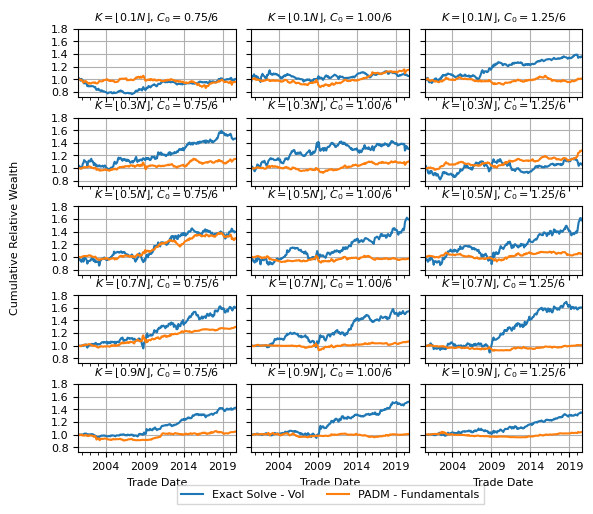

In [9]:
max_y = 0
min_y = 0.8
fig, axs = plt.subplots(len(cardinalities), len(turnovers),
                        sharex=True, sharey = True, figsize=(6.5,5.5))
for (i ,j) in product(range(len(cardinalities)), range(len(turnovers))):
    turnover = turnovers[j]
    card = cardinalities[i]
    svm_wealth = wealth(oot_returns_svm_dict[(card, turnover)])
    mvo_wealth = wealth(oot_returns_mvo_dict[(card, turnover)])
    adm_wealth = wealth(oot_returns_adm_dict[(card, turnover)])
    T = len(adm_wealth)
    (svm_wealth/mvo_wealth).plot(label = 'Exact Solve - Vol', fontsize = 8, ax=axs[i, j])
    (adm_wealth/mvo_wealth).plot(label = 'PADM - Fundamentals', fontsize = 8, ax=axs[i, j])
    card_string = card_strings[i]
    turnover_string = turnover_strings[j]
    axs[i, j].set_title(card_string + ", " + turnover_string, fontsize = 8)
    max_ = max(np.max((adm_wealth/mvo_wealth)), np.max((svm_wealth/mvo_wealth)))
    if max_ > max_y:
        max_y = max_
axs[4, 1].legend(loc='upper center',
             bbox_to_anchor=(0.5, -0.4),
                 fancybox=False,
                 shadow=False, ncol=3,
                 fontsize = 8)

for ax in axs:
    for sub_ax in ax:
        sub_ax.yaxis.set_tick_params(which='minor', bottom=False)
        sub_ax.set_yticks([min_y+i*0.2 for i in range(2+int((max_y - min_y)/0.2))])
        sub_ax.grid()
        sub_ax.set_xlabel("Trade Date",fontsize = 8)
# fig.supxlabel('Trade Date',fontsize = 8)
fig.supylabel("Cumulative Relative Wealth",fontsize = 8)
#plt.tight_layout()
fig.subplots_adjust(wspace = 0.1, hspace=0.3)
#plt.setp(axs, yticks = [i*0.2 for i in range(2+int(max_y/0.2))])

plt.savefig(img_path + epsilons_desc[epsilon] + "p12.svg", dpi = dpi_setting)
epsilons_desc[epsilon]

In [18]:
#checking turnovers
print(weights_svm.diff().abs().sum().sum())
print(weights_adm.diff().abs().sum().sum())
print(weights_mvo.diff().abs().sum().sum())

49.95771022806299
50.41668997889401
50.415421097750375


# Making Latex Tables

In [12]:
def RetStats(returns, rf=None, geomean=True):
    """Assumes returns is a pandas Series"""
    if rf is None:
        returns_rf = returns
    else:
        returns_rf = returns - rf
    P = 12
    P05 = P ** 0.5

    if geomean:
        mean = gmean(1 + returns_rf) - 1
    else:
        mean = returns_rf.mean()
    return "{:.1%}".format(P * mean), "{:.1%}".format(P05 * returns_rf.std()), "{0:.3}".format(P * mean / (P05 * returns_rf.std()))

In [13]:
def highlight_max(data, color='grey'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        if data.columns[0] == "$\sigma$":
            is_max = data == data.min().min()
        else:
            is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [14]:
df_cols = []

for i in range(len(cardinalities)):
    df_rows = []

    for j in range(len(turnovers)):
        turnover = turnovers[j]
        card = cardinalities[i]
        card_string = card_strings[i]
        turnover_string = turnover_strings[j]
        oot_returns_svm = oot_returns_svm_dict[(card, turnover)]
        oot_returns_mvo = oot_returns_mvo_dict[(card, turnover)]
        oot_returns_adm = oot_returns_adm_dict[(card, turnover)]
        row_tuples = [(turnover_string, "MVO"), (turnover_string, "Exact Solve - Vol"), (turnover_string, "PADM - Fundamentals")]
        row_index = pd.MultiIndex.from_tuples(row_tuples)

        col_tuples =[(card_string, "$\mu$"), (card_string,"$\sigma$"), (card_string,"S.R")]
        col_index = pd.MultiIndex.from_tuples(col_tuples)

        out = pd.DataFrame([RetStats(oot_returns_mvo, rf/100), RetStats(oot_returns_svm, rf/100), RetStats(oot_returns_adm, rf/100)],
                           index = row_index, columns = col_index)

        df_rows.append(out)

    column = pd.concat(df_rows)
    df_cols.append(column)

In [15]:
pd.concat(df_cols, axis = 1).to_csv(img_path+ epsilons_desc[epsilon]+".csv")

In [16]:
pd.concat(df_cols, axis = 1)

$K = \lfloor 0.1N \rfloor$                  \
                                                        $\mu$ $\sigma$    S.R   
$C_0 = 0.75/6$ MVO                                      11.9%    12.4%  0.966   
               Exact Solve - Vol                        12.0%    13.1%  0.914   
               PADM - Fundamentals                      11.7%    13.4%  0.879   
$C_0 = 1.00/6$ MVO                                      11.2%    12.2%  0.916   
               Exact Solve - Vol                        11.5%    13.3%  0.862   
               PADM - Fundamentals                      11.9%    13.0%  0.915   
$C_0 = 1.25/6$ MVO                                      10.9%    12.1%  0.905   
               Exact Solve - Vol                        12.5%    12.7%  0.978   
               PADM - Fundamentals                      11.0%    11.9%  0.919   

                                   $K = \lfloor0.3N\rfloor$                  \
                                                      $\mu$ $\sigma$    S.R   
$C_0 = 0.75/6$ MVO                                    11.9%    12.4%  0.966   
               Exact Solve - Vol                      13.9%    14.7%  0.944   
               PADM - Fundamentals                    12.6%    12.8%  0.986   
$C_0 = 1.00/6$ MVO                                    11.2%    12.2%  0.916   
               Exact Solve - Vol                      12.5%    13.4%  0.933   
               PADM - Fundamentals                    11.7%    12.2%   0.96   
$C_0 = 1.25/6$ MVO                                    10.9%    12.1%  0.905   
               Exact Solve - Vol                      11.2%    14.7%  0.763   
               PADM - Fundamentals                    12.1%    12.1%   1.01   

                                   $K = \lfloor0.5N \rfloor$                  \
                                                       $\mu$ $\sigma$    S.R   
$C_0 = 0.75/6$ MVO                                     11.9%    12.4%  0.966   
               Exact Solve - Vol                       13.6%    15.5%  0.876   
               PADM - Fundamentals                     13.2%    12.5%   1.06   
$C_0 = 1.00/6$ MVO                                     11.2%    12.2%  0.916   
               Exact Solve - Vol                       13.5%    15.3%  0.886   
               PADM - Fundamentals                     11.1%    12.6%  0.877   
$C_0 = 1.25/6$ MVO                                     10.9%    12.1%  0.905   
               Exact Solve - Vol                       13.2%    15.9%  0.828   
               PADM - Fundamentals                     11.1%    12.2%  0.914   

                                   $K = \lfloor0.7N \rfloor$                  \
                                                       $\mu$ $\sigma$    S.R   
$C_0 = 0.75/6$ MVO                                     11.9%    12.4%  0.966   
               Exact Solve - Vol                       14.3%    15.2%  0.939   
               PADM - Fundamentals                     13.2%    12.2%   1.08   
$C_0 = 1.00/6$ MVO                                     11.2%    12.2%  0.916   
               Exact Solve - Vol                       13.4%    14.5%  0.922   
               PADM - Fundamentals                     11.5%    12.6%  0.919   
$C_0 = 1.25/6$ MVO                                     10.9%    12.1%  0.905   
               Exact Solve - Vol                       13.3%    14.8%    0.9   
               PADM - Fundamentals                     11.0%    12.1%  0.909   

                                   $K = \lfloor0.9N \rfloor$                  
                                                       $\mu$ $\sigma$    S.R  
$C_0 = 0.75/6$ MVO                                     11.9%    12.4%  0.966  
               Exact Solve - Vol                       13.7%    13.6%   1.01  
               PADM - Fundamentals                     12.2%    12.8%  0.951  
$C_0 = 1.00/6$ MVO                                     11.2%    12.2%  0.916  
               Exact Solve - Vol     

In [17]:
out.style